In [2]:
from Preprocessing import Preprocessing
ps = Preprocessing()

images = ['img/a0.png', 'img/a1.png']
results = ps.do_it(images)
print('Puzzles: {}'.format(len(results)))

Files: 2
Puzzles: 54


# Próba match template

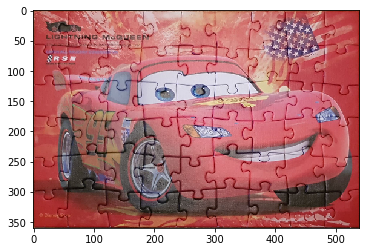

(360, 540, 3)


In [2]:
import cv2
import numpy as np

img = cv2.imread('img/aa.png')

size = [9, 6]

rows,cols,ch = img.shape

pts1 = np.float32([[384-5,64-5],[270-5,1128+5],[1898+5,108-5],[1980+5,1120+5]])
pts2 = np.float32([[0,0],[0,600*size[1]],[600*size[0],0],[600*size[0],600*size[1]]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(600*size[0],600*size[1]))

dst = cv2.resize(dst, (0,0), None, fx=0.1, fy=0.1)
ps.draw(dst)

print(dst.shape)

In [3]:
correct = np.array([
    [30,50,43,39,52,6,7,13,19],
    [36,44,32,45,47,2,0,21,17],
    [37,38,41,40,48,24,5,4,10],
    [42,31,51,46,35,25,28,29,20],
    [49,53,33,34,26,12,3,15,8],
    [1,9,27,14,16,11,18,23,22]
])

In [11]:
import copy
base = copy.deepcopy(dst)
base = adjust_gamma(base)

templates = []
for el in results:
    loc = el[0][0].copy()

    loc = cv2.warpAffine(loc, cv2.getRotationMatrix2D((500,500), 270, 1.0), (1000, 1000))
    loc = adjust_gamma(loc)
    templates.append(loc)
    
own_try = np.zeros(correct.shape)

for i, template in enumerate(templates):
    method = cv2.TM_CCOEFF_NORMED
    template = cv2.resize(template, (0,0), None, fx=0.1, fy=0.1)
    template = template[20:80, 20:80]

    c, w, h = template.shape[::-1]

    res = cv2.matchTemplate(base,template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    cy = top_left[0] + (h)//2
    cx = top_left[1] + (w)//2

    a = base.shape[0]//6
    b = base.shape[1]//9

    a, b = cy//a, cx//b

    if own_try[b,a] == 0:
        own_try[b,a] = i
        #cv2.rectangle(base, top_left, bottom_right, (255,255,0), 1)

In [12]:
own_try

array([[ 0., 50., 43., 36.,  0.,  0.,  7., 13., 20.],
       [ 0.,  0.,  0., 31., 47.,  2.,  0., 19., 49.],
       [37., 38., 12.,  6.,  1., 24.,  5.,  0., 10.],
       [42.,  0., 51., 46.,  0., 25., 18., 29., 21.],
       [ 0., 26.,  0.,  0.,  0.,  0.,  3.,  4.,  8.],
       [14.,  9.,  0.,  0., 16., 11.,  0., 23., 22.]])

In [16]:
print('Błąd: {:.3f} (poprawnych/wszystkich)'.format(np.count_nonzero(np.subtract(own_try,correct)==0)/(size[0]*size[1])))

Błąd: 0.444 (poprawnych/wszystkich)


In [9]:
def adjust_gamma(image, gamma=2.5):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

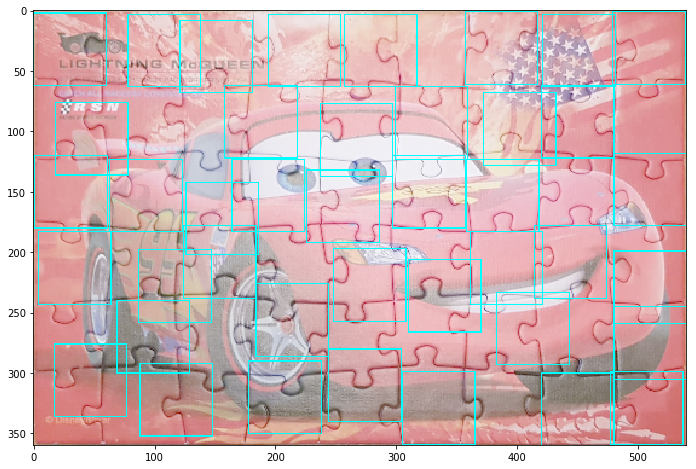

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

ps.draw(base)

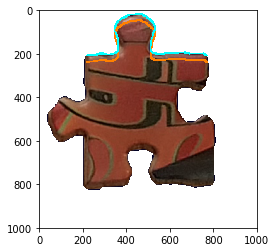

In [25]:
d = results[31][0][0].copy()
for el in results[31][1][0]:
    cv2.circle(d, (el[1], el[0]), 1, (255,255,0))
    cv2.circle(d, (el[1], el[0]+30), 1, (0,128,256))

ps.draw(d)